## Camera Calibration
Compute the camera calibration matrix and distortion coefficients based on the given set of chessboard images.

17


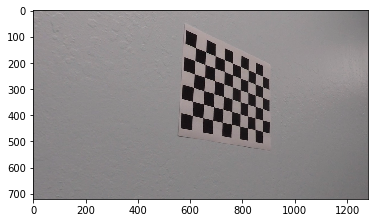

In [5]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# Read in a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# print(images)

# Arrays to store object points and image points from all image points
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

for image_file in images:
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # draw_img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        # plt.imshow(draw_img)

# Camera calibration based on objpoints and imgpoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Show an example of undistorted image
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
print(len(imgpoints))


## Distortion Correction

In [7]:
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Setup output path
out_path = "./output_images/"
input_path = "./test_images/"

# Read in test images
import os
test_images = os.listdir(input_path)

# Do distortion correction
for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    cv2.imwrite(os.path.join(out_path, "undist_"+img_path), undist_img)


## Thresholded Binary Images

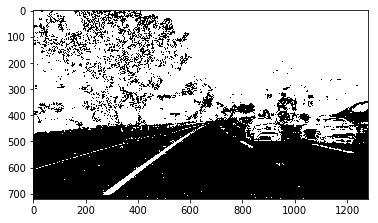

In [40]:
def threshold_image(img, sobelx_thresh = (20,100), h_thresh = (15,100), s_thresh = (90,255)):
    # Convert to HSV color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sobelx_thresh[0]) & (scaled_sobelx <= sobelx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Combine binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (h_binary == 1) | (sxbinary == 1) ] = 255
    return combined_binary
    
    # Return stacked binary images
    # color_binary = np.dstack(( sxbinary, h_binary, s_binary))
    # gray_binary = cv2.cvtColor(color_binary, cv2.COLOR_RGB2GRAY)
    # return gray_binary

for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    
    # Display a binary image sample
    plt.imshow(th_undist_img, 'gray')
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "th_undist_"+img_path), th_undist_img)

## Perspective Transform

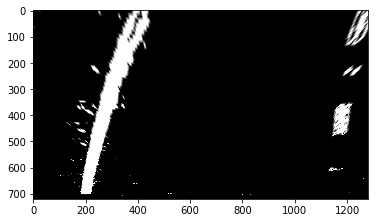

In [98]:
def perspective_trans(img, src, dst):
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
    return warped, M

# Manually select source and destination coordinates from straight lines
src = np.float32([[200,700],[555,470],[725,470],[1100,700]])
dst = np.float32([[110,700],[110,100],[1100,100],[1100,700]])

for img_path in test_images:
    img = cv2.imread(input_path + img_path)
    undist_img = undistort_image(img, mtx, dist)
    th_undist_img = threshold_image(undist_img)
    warp_img, _ = perspective_trans(th_undist_img, src, dst)
    
    # Display a binary image sample
    plt.imshow(warp_img, 'gray')
    
    # Save binary image
    cv2.imwrite(os.path.join(out_path, "warp_"+img_path), warp_img)

## Find Lane boundary